The goal here is to examine performance of the sampler when, as in the Cayo pedigree. Does the sampling algorithm converge in reasonable time, or does it get "trapped" in certain arrangements of genotypes for long periods of time? Can we at all recover founding population minor allele frequency and the genotypes?

Load packages and functions.

In [2]:
using PyPlot;
using Distributions;
include("../singleallelesampler.jl");
include("../singleallelegibbs.jl");

INFO: Loading help data...


Simulate pedigree and genotype, then remove some genotypes (genotypes set to -1).

In [60]:
init = 30;
ngen = 5;
popcap=50;
ped = pedigree_pedsim(init,ngen,popcap);
geno = pedigree_genosim(ped,0.4)[1];
print(geno')

[0 1 0 1 1 0 0 1 0 1 1 2 1 1 0 2 2 2 1 0 0 2 1 1 2 2 1 1 1 2 1 0 0 2 1 1 1 0 1 1 0 1 1 2 1 2 1 1 1 1 1 2 0 0 0 2 0 1 2 2 0 1 1 1 0 1 2 1 0 1 1 2 2 0 1 0 0 1 1 1 1 0 1 0 2 2 1 1 2 0 1 0 2 2 1 2 1 0 1 0 2 1 1 1 0 1 1 0 0 1 2 0 0 0 1 0 1 0 1 0 2 0 0 2 1 1 2 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 2 1 0 1 2 1 2 1 2 1 1 1 0 1 0 0 2 0 1 1 1 1 2 1 1 2 0 0 1 1 0 1 1 1 1 1 1 0 0 2 0 0 1 2 2 1 1 0 1 1 1 0 1 0 0 1 1 1 0 2 1 2 0 1 1 1 0 1 1 1 1 1 2 2 1 0 2 0 2 1 1 1 1 1 0]

In [61]:
geno_obs = geno[:];
cullgen = 2;
gensize = min(init * 2.^[0:(ngen-1)],popcap);
miss = 1:cumsum(gensize)[cullgen]
geno_obs[miss] = -1;
print(geno_obs)

[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,1,0,2,2,1,1,2,0,1,0,2,2,1,2,1,0,1,0,2,1,1,1,0,1,1,0,0,1,2,0,0,0,1,0,1,0,1,0,2,0,0,2,1,1,2,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,0,1,2,1,0,1,2,1,2,1,2,1,1,1,0,1,0,0,2,0,1,1,1,1,2,1,1,2,0,0,1,1,0,1,1,1,1,1,1,0,0,2,0,0,1,2,2,1,1,0,1,1,1,0,1,0,0,1,1,1,0,2,1,2,0,1,1,1,0,1,1,1,1,1,2,2,1,0,2,0,2,1,1,1,1,1,0]

Run the sampler.

In [62]:
@time gs,maf,ϵ,z,badz =  pedigree_genogibbs(geno_obs,ped,5000);

elapsed time: 40.928460131 seconds (21727999992 bytes allocated, 36.20% gc time)


In [73]:
thin = 501:3:1500;

First examine the series of sampled MAFs. The x-axis is iteration number, and the y-axis is the value for the parameter sampled at that iteration. We want it to look like a [hairy caterpillar](http://support.sas.com/documentation/cdl/en/statug/63962/HTML/default/images/mip81__.png), but if we are getting poor performance it will have [slow movement over time](http://users.stat.umn.edu/~geyer/mcmc/long2.gif).

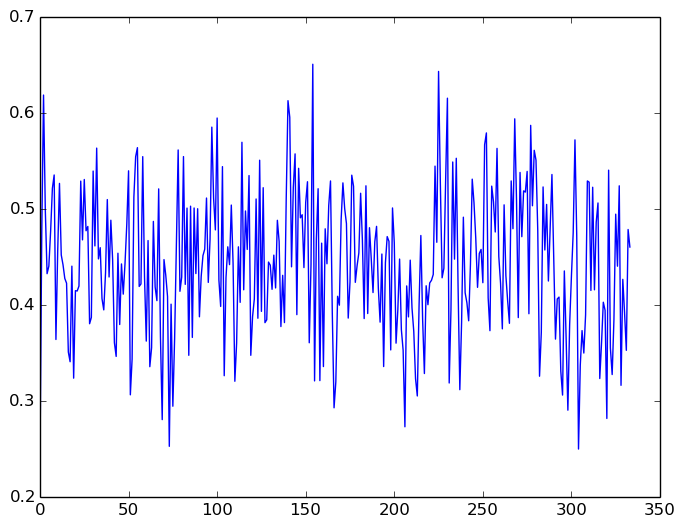

In [74]:
PyPlot.plot(maf[thin]);

That looks reasonably like a hairy caterpillar. I declare victory. Also, the sampled MAF values are all in a reasonable neighborhood around the true value.

Next we look at $\epsilon$, the genotyping error rate. This is a bit silly because here the true value is 0, but again we want to make sure nothing crazy is happening in this easiest of test cases.

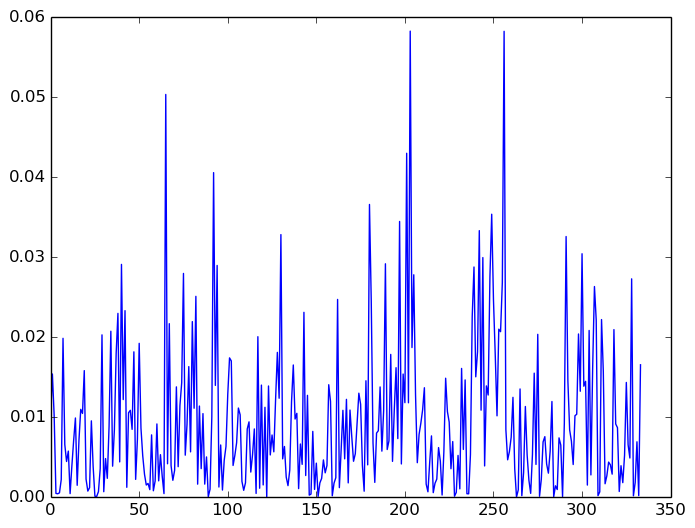

In [75]:
plot(ϵ[thin]);

Seems hairy-caterpillary enough for government work.

Now for the more interesting point: how do we do on the emonkeys with unknown genotypes? There are 80 of them and they are discrete {0,1,2} so doing our caterpillar plots would be rather time consuming. Instead, we're just going to look at a heat map, where the color intensity is minor allele count, along the y axis is emonkey ID, and x axis is iteration number.

What we want is for it to look like white noise where each row has a different proportion of the three colors, but the colors are more or less randomly intermixed.

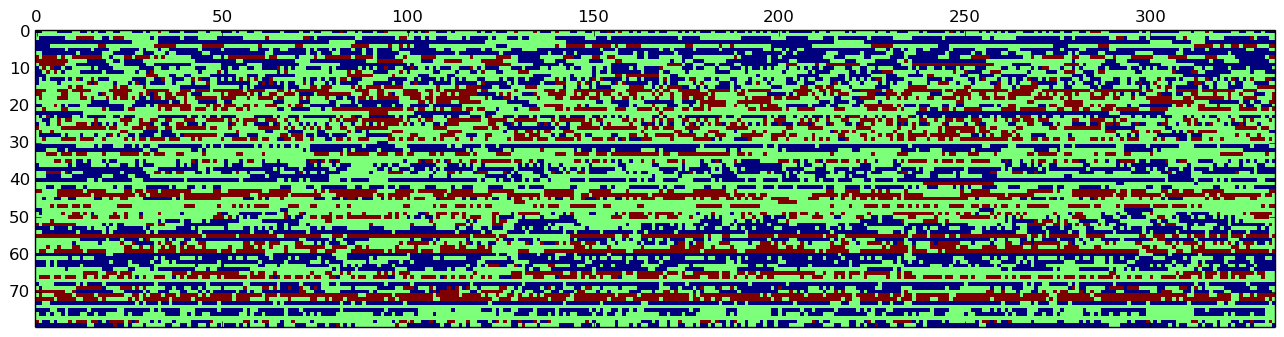

In [76]:
PyPlot.matshow(gs[miss,thin]);

That's... not bad? If you look closely, there are some emonkeys that seem to alternate longish stretches of differet colors (one of the guys right below 30, for instance). However, those stretches are not that long -- as in, they are not lasting, like, more than 1/3 of the plot.

So I'd say convergence is adequate, especially since right now we don't really care about doing exact inference on missing genotypes. We just need convergence to be good enough that it doesn't screw up the stuff we do care about.

But how are we doing on actually recovering the missing genotypes? We'll plot the mean of the posteriors of the genotypes for each emonkey against the true genotypes.

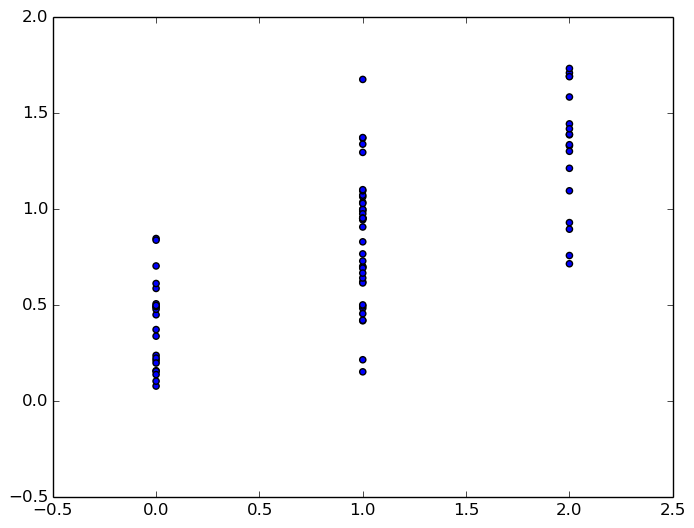

In [78]:
PyPlot.scatter(geno[miss],sum(gs[miss,[thin]],2)/350);

Unsurprisingly, there's tons of noise. It's not surprising that we can't do super great inference on past generations, but it's reassuring that we're getting something at least (at least in that it indicates that the code is working).